In [3]:
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
%matplotlib inline
plt.style.use('ggplot')

In [4]:
def func(x):
    return np.sin(
        x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

In [5]:
def gen_data(N=600,
             frac=0.4,
             low_noise_var=0.005,
             high_noise_var=0.3,
             plot_flag=False):
    """
    N - number of training observations
    a - fraction of observations in mode 2 (high noise mode)
    """
    N2 = int(frac * N / 2)  # number of observations in mode 2 (high noise)
    # generate input observations X
    #     X = rnd.randn(N, 1) * 2 - 1 # X values
    # X = np.random.rand(N, 1) * 2 - 1  # X values
    X = np.linspace(-1.0, 1.0, N)[:, None]

    # generate target observations Y
    # Y = np.zeros([N, 1])
    Y = func(X)  # + 3
    Y[X > 0] += low_noise_var * np.random.randn((Y[X > 0]).shape[0])
    Y[X < 0] += high_noise_var * np.random.randn(
        (Y[X < 0]).shape[0])  # add noise to subset of target observations Y
    #     Y[N2:-N2] += low_noise_var * rnd.randn(N-2*N2,1)
    #     Y[-N2:] += high_noise_var  * rnd.randn(N2,1) # add noise to subset of target observations Y
    #     Y[:N2] += high_noise_var* rnd.randn(N2,1) # add noise to subset of target observations Y

    # Bernoulli indicator variable, 0 = low noise, 1 = high noise
    a = np.zeros([N, 1])
    a[X < 0] = 1
    # a[-N2:] = 1
    # a[:N2] = 1

    if plot_flag is True:
        plot_data(X, Y, a, N2, func)

    return X, Y, a


def plot_data(X, Y, a, N2, func, title=None):
    plt.figure(figsize=(12, 4))
    plt.plot(X, Y, 'x', color='k', alpha=0.4, label="Observations")

    #     plt.fill_between(X[:N2, 0], -1.8, 1.8, color='c', alpha=0.2, lw=1.5)
    plt.fill_between(X[a == 0],
                     -1.8,
                     1.8,
                     color='m',
                     alpha=0.2,
                     lw=1.5,
                     label='Mode 1 (low noise)')
    plt.fill_between(X[-N2:, 0],
                     -1.8,
                     1.8,
                     color='c',
                     alpha=0.2,
                     lw=1.5,
                     label='Mode 2 (high noise)')
    #     Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
    Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
    Yt = func(Xt)
    plt.plot(Xt, Yt, c='k')  # , label="Underlying function"
    plt.xlabel("$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$", fontsize=20)
    plt.ylabel("$\mathbf{s}_t$", fontsize=20)
    plt.tick_params(labelsize=20)
    plt.ylim(-2.1, 2.1)
    plt.legend(loc='lower right', fontsize=15)
    plt.title(title)
    plt.show()

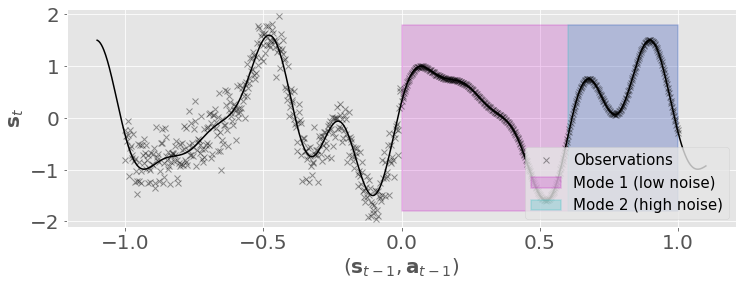

In [6]:
N = 800 # number of training observations
X, Y, a = gen_data(N, plot_flag=True)
# X = X.reshape(-1, 2)
# Y = Y.reshape(-1, 2)

In [7]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []

    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

In [8]:
from gpflow.training import monitor as mon
def run_adam(model, maxiter=450):
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=maxiter)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

def plot_loss(logger):
    plt.plot(-np.array(logger.logf))
    plt.xlabel('iteration (x10)')
    plt.ylabel('ELBO');

In [9]:
def plot_model(m,
               f1=False,
               f2=False,
               a=False,
               a_true=None,
               h=False,
               y=False,
               save_name=False):
    fig = plt.figure(figsize=(12, 4))
    pX = np.linspace(-1, 1, 100)[:, None]  # Test locations

    plt.plot(m.X.value,
             m.Y.value,
             'x',
             color='k',
             label='Observations',
             alpha=0.2)

    if h is True:
        a_mu, a_var = m.predict_h(pX)  # Predict alpha values at test locations
        plt.plot(pX, a_mu, color='olive', lw=1.5)
        plt.fill_between(pX[:, 0], (a_mu - 2 * a_var**0.5)[:, 0],
                         (a_mu + 2 * a_var**0.5)[:, 0],
                         color='olive',
                         alpha=0.4,
                         lw=1.5,
                         label='Separation manifold GP')

    if a is True:
        a_mu, a_var = m.predict_a(pX)  # Predict alpha values at test locations
        plt.plot(pX, a_mu, color='olive', lw=1.5)
        plt.fill_between(pX[:, 0], (a_mu - 2 * a_var**0.5)[:, 0],
                         (a_mu + 2 * a_var**0.5)[:, 0],
                         color='blue',
                         alpha=0.4,
                         lw=1.5,
                         label='$\\alpha$')

    if a_true is not None:
        plt.plot(X, a_true, '-', color='k', label='True $\\alpha$', alpha=0.9)

    pY, pYv = m.predict_f(pX)
    def plot_f(idx, col, feats, label=None):
        line, = plt.plot(pX, pY[idx], color=col, alpha=0.6, lw=1.5)
        plt.fill_between(pX[:, 0], (pY[idx] - 2 * pYv[idx]**0.5)[:, 0],
                         (pY[idx] + 2 * pYv[idx]**0.5)[:, 0],
                         color=col,
                         alpha=0.2,
                         lw=1.5,
                         label=label)
        plt.plot(m.features[idx].Z.value,
                 np.zeros(m.features[idx].Z.value.shape),
                 'k|',
                 mew=2)
    if f1 is True:
        plot_f(0, 'm', 'k|', 'Mode 1 - low noise')

    if f1 is True:
        plot_f(1, 'c', 'b|', 'Mode 2 - high noise')

    if y is True:
        pY, pYv = m.predict_y(pX)
        line, = plt.plot(pX, pY, color='royalblue', alpha=0.6, lw=1.5)
        plt.fill_between(pX[:, 0], (pY - 2 * pYv**0.5)[:, 0],
                         (pY + 2 * pYv**0.5)[:, 0],
                         color='royalblue',
                         alpha=0.2,
                         lw=1.5)

    fig.legend(loc='lower right', fontsize=15)
    plt.xlabel('$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$', fontsize=30)
    plt.ylabel('$\mathbf{s}_t$', fontsize=30)
    #     plt.xlim(-1.0, 1.2)
    plt.tick_params(labelsize=20)
    if save_name is not False:
        plt.savefig(save_name, transparent=True, bbox_inches='tight')
    plt.show()

In [10]:
from gpflow import kullback_leiblers, settings, transforms, features
from gpflow.conditionals import conditional, Kuu
from gpflow.decors import params_as_tensors
from gpflow.models.model import GPModel
from gpflow.params import DataHolder, Minibatch, Parameter, ParamList
from gpflow.mean_functions import Zero
from gpflow.models.model import Model
from gpflow.decors import params_as_tensors, autoflow
from gpflow.quadrature import ndiagquad

float_type = gpflow.settings.float_type

In [11]:
from gpflow.likelihoods import Likelihood, SwitchedLikelihood, Gaussian, Bernoulli

def inv_probit(x):
    jitter = 1e-3  # ensures output is strictly between 0 and 1
    return 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter


class BernoulliGaussian(Likelihood):
    def __init__(self, variance_low=0.005, variance_high=0.3, invlink=inv_probit, **kwargs):
        super().__init__(**kwargs)
        self.invlink = invlink
        variance_low = Parameter(
            variance_low, transform=transforms.positive, dtype=settings.float_type)
        variance_high = Parameter(
            variance_high, transform=transforms.positive, dtype=settings.float_type)

        variances = [variance_low, variance_high]
        self.variances = ParamList(variances)
        self.likelihood_bern = Bernoulli()
#         self.variance_low.trainable = False
#         self.variance_high.trainable = False

    @params_as_tensors
    def predict_mean_and_var(self, Fmu, Fvar, idx):
        return tf.identity(Fmu), Fvar + self.variances[idx]

    # @params_as_tensors
    # def predict_mean_and_var(self, Fmu, Fvar):
    #     mus, variances = []
    #     for mu, var, lvar in zip(Fmu, Fvar, self.variances):
    #         mus.append(tf.identity(mu))
    #         variances.append(var + lvar)
    #     return mus, variances

    # @params_as_tensors
    # def predict_mean_and_var_f_high(self, Fmu, Fvar):
    #     return tf.identity(Fmu), Fvar + self.variance_high

    # @params_as_tensors
    # def predict_mean_and_var_f_low(self, Fmu, Fvar):
    #     return tf.identity(Fmu), Fvar + self.variance_low

    @params_as_tensors
    def predict_mean_and_var_a(self, Hmu, Hvar):
        return self.likelihood_bern.predict_mean_and_var(Hmu, Hvar)

    @params_as_tensors
    def predict_mean_a(self, H):
        return inv_probit(H)

In [12]:
class BMNSVGP(Model):

    def __init__(self, X, Y, var_low, var_high, minibatch_size=None):
        """
        - X is a data matrix, size N x D
        - Y is a data matrix, size N x P
        """
        Model.__init__(self, name="BMNSVGP")
        if minibatch_size is not None:
            self.X = Minibatch(X, batch_size=minibatch_size, seed=0)
            self.Y = Minibatch(Y, batch_size=minibatch_size, seed=0)
        else:
            self.X = Dataholder(X)
            self.Y = Dataholder(Y)

        self.num_data = X.shape[0]
        self.whiten = True
        # self.whiten = False
#         num_inducing = len(self.feature)

        # init separation GP
        self.mean_function_h = Zero(output_dim=1)
        self.kern_h = gpflow.kernels.RBF(input_dim=X.shape[1])
        feat = None
        M = 50
        idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
        Z = X[idx, ...].reshape(-1, X.shape[1])
        self.feature_h = features.inducingpoint_wrapper(feat, Z)
        self.feature_h.trainable = False
        # init variational parameters
        # TODO: auto select number of inducing points
        q_mu_h = np.zeros((M, 1)) + rnd.randn(M, 1)
        q_sqrt_h = np.array([10*np.eye(M, dtype=settings.float_type) for _ in range(1)])
        self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=M, num_latent=1, q_mu=q_mu_h, q_sqrt=q_sqrt_h)
        #         self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=50, num_latent=1)

        # init 2 dynamics GPs for each output dimension
        kernels, mean_functions, feat_list, q_mus, q_sqrts = [], [], [], [], []

        # init dynamics GPs for each mode
        for i in range(2):
            # init mean functions
            mean_functions.append(Zero(output_dim=Y.shape[1]))

            # init kernels
            # Create list of kernels for each output
            # kern_list = [gpflow.kernels.RBF(X.shape[1]) for _ in range(Y.shape[1])]
            kern = gpflow.kernels.RBF(input_dim=X.shape[1])
            # Create multioutput kernel from kernel list
            # kernel = mk.SeparateIndependentMok(kern_list)
            kernels.append(kern)
            # self.kernels.append(kern_list)

            # init features
            # initialisation of inducing input locations, one set of locations per output
            # Zs = [X[np.random.permutation(len(X))[:M],...].copy() for _ in range(Y.shape[1])]
            # initialise as list inducing features
            # feature_list = [gpflow.features.InducingPoints(Z) for Z in Zs]
            # create multioutput features from feature_list
            # feature = mf.SeparateIndependentMof(feature_list)
            # self.features.append(feature)
            idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
            Z = X[idx, ...].reshape(-1, X.shape[1])
            feature = features.inducingpoint_wrapper(feat, Z)
            feature.trainable = False
            feat_list.append(feature)

            # init variational inducing points
            q_mu, q_sqrt = self._init_variational_parameters(num_inducing=M, num_latent=Y.shape[1])
            # q_mu = np.zeros((M, 1)) + rnd.randn(M, 1)
            # q_sqrt = np.array([10*np.eye(M, dtype=settings.float_type) for _ in range(1)])
            q_mus.append(q_mu)
            q_sqrts.append(q_sqrt)

        self.kernels = ParamList(kernels)
        self.features = ParamList(feat_list)
        self.mean_functions = ParamList(mean_functions)
        self.q_mus = ParamList(q_mus)
        self.q_sqrts = ParamList(q_sqrts)

        # init likelihood
        self.likelihood = BernoulliGaussian(variance_low=var_low, variance_high=var_high)

    def _init_variational_parameters(self, num_inducing, num_latent, q_mu=None, q_sqrt=None, q_diag=None):
        q_mu = np.zeros((num_inducing, num_latent)) if q_mu is None else q_mu
        q_mu = Parameter(q_mu, dtype=settings.float_type)  # M x P

        if q_sqrt is None:
            if q_diag:
                q_sqrt = Parameter(np.ones((num_inducing, num_latent), dtype=settings.float_type),
                                        transform=transforms.positive)  # M x P
            else:
                q_sqrt = np.array([np.eye(num_inducing, dtype=settings.float_type) for _ in range(num_latent)])
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # P x M x M
        else:
            if q_diag:
                assert q_sqrt.ndim == 2
                num_latent = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.positive)  # M x L/P
            else:
                assert q_sqrt.ndim == 3
                num_latent = q_sqrt.shape[0]
                num_inducing = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # L/P x M x M
        return q_mu, q_sqrt

    @params_as_tensors
    def build_prior_KL(self, feature, kern, q_mu, q_sqrt):
        if self.whiten:
            K = None
        else:
            K = Kuu(feature, kern, jitter=settings.numerics.jitter_level)  # (P x) x M x M

        return kullback_leiblers.gauss_kl(q_mu, q_sqrt, K)

    @params_as_tensors
    def _sample_e_h(self, dist_h, f_means, num_samples=1000):
        h = tf.reshape(dist_h.sample(num_samples), [-1, num_samples])
        p_a_0 = 1 - inv_probit(h)

        p_y = []
        for f_mean, variance in zip(f_means, self.likelihood.variances):
            dist_y = tf.distributions.Normal(loc=f_mean, scale=variance)
            p_y.append(dist_y.prob(self.Y))
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y[0] * p_a_0 + p_y[1] * (1 - p_a_0)), axis=1)

    @params_as_tensors
    def _sample_e_f(self, dist_fs, h, num_samples=1000):
        p_a_0 = 1 - inv_probit(h)

        p_y = []
        for dist_f, variance in zip(dist_fs, self.likelihood.variances):
            f = tf.reshape(dist_f.sample(num_samples), [-1, num_samples])

            dist_y = tf.distributions.Normal(loc=f, scale=variance)
            p_y.append(dist_y.prob(self.Y))
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y[0] * p_a_0 + p_y[1] * (1 - p_a_0)), axis=1)

    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        # Get prior KL.
        KL_h = self.build_prior_KL(self.feature_h, self.kern_h, self.q_mu_h, self.q_sqrt_h)

        # Lets get conditional p(h_n | U_h, x_n) for all N
        h_mean, h_var = self._build_predict_h(self.X, full_cov=False, full_output_cov=False)
        dist_h = tf.distributions.Normal(loc=h_mean, scale=h_var)

        KL_f = 0
        f_means, f_vars, dist_fs = [], [], []
        for feature, kern, mean_function, q_mu, q_sqrt in zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts):
            # Get prior KL.
            KL_f += self.build_prior_KL(feature, kern, q_mu, q_sqrt)

            # Lets get conditionals p(f_n_1 | U_f_1, x_n) and p(f_n_2 | U_f_2, x_n) for all N
            f_mean, f_var = self._build_predict_f(self.X, feature, kern, mean_function, q_mu, q_sqrt, full_cov=False, full_output_cov=False)
            f_means.append(f_mean)
            f_vars.append(f_var)

            dist_fs.append(tf.distributions.Normal(loc=f_mean, scale=f_var))

        # Lets calculate the variatonal expectations
        var_exp_h = self._sample_e_h(dist_h, f_means, num_samples=1)
        var_exp_f = self._sample_e_f(dist_fs, h_mean, num_samples=1)
        var_exp = var_exp_f + var_exp_h

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)
        return tf.reduce_sum(var_exp) * scale - KL_f - KL_h

    @params_as_tensors
    def _build_predict_h(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_h, self.kern_h, self.q_mu_h, q_sqrt=self.q_sqrt_h, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_h(Xnew), var

    @params_as_tensors
    def _build_predict_f(self, Xnew, feature, kern, mean_function, q_mu, q_sqrt, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, feature, kern, q_mu, q_sqrt=q_sqrt, full_cov=full_cov, white=self.whiten, full_output_cov=full_output_cov)
        return mu + mean_function(Xnew), var

    @autoflow((settings.float_type, [None, None]))
    def predict_a(self, Xnew):
        h_mean, h_var = self._build_predict_h(Xnew)
        return self.likelihood.predict_mean_and_var_a(h_mean, h_var)

    @autoflow((settings.float_type, [None, None]))
    def predict_h(self, Xnew):
        return self._build_predict_h(Xnew)

    @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_f(self, Xnew):
        means, variances = [], []
        for idx, (feature, kern, mean_function, q_mu, q_sqrt) in enumerate(zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts)):
            mean, variance = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            mean, variance = self.likelihood.predict_mean_and_var(mean, variance, idx)
            means.append(mean)
            variances.append(variance)
        return means, variances

#     @autoflow((settings.float_type, [None, None]))
    def predict_y(self, Xnew):
        a_mean, a_var = self.predict_a(Xnew)
        f_mean, f_var = self.predict_f(Xnew)
        f_mean = f_mean[0] * (1-a_mean) + f_mean[1] * a_mean
        f_var = f_var[0] * (1-a_mean) + f_var[1] * a_mean
        return f_mean, f_var

    # @autoflow((settings.float_type, [None, None]))
    # def predict_f_low(self, Xnew):
    #     pred_f_mean, pred_f_var = self._build_predict_f_low(Xnew)
    #     return self.likelihood.predict_mean_and_var_f_low(pred_f_mean, pred_f_var)

    # @autoflow((settings.float_type, [None, None]))
    # def predict_f_high(self, Xnew):
    #     pred_f_mean, pred_f_var = self._build_predict_f_high(Xnew)
    #     return self.likelihood.predict_mean_and_var_f_high(pred_f_mean, pred_f_var)

# #     @autoflow((settings.float_type, [None, None]))
#     def predict_y(self, Xnew):
#         # TODO: how to incorporate unc in assignment???
#         pred_f_mean_low, pred_f_var_low = self.predict_f_low(Xnew)
#         pred_f_mean_high, pred_f_var_high = self.predict_f_high(Xnew)
#         pred_a_mean, pred_a_var = self.predict_a(Xnew)
#         f_mean = pred_f_mean_low * (1-pred_a_mean) + pred_f_mean_high * pred_a_mean
#         f_var = pred_f_var_low * (1-pred_a_mean) + pred_f_var_high * pred_a_mean
#         return f_mean, f_var

In [13]:
gpflow.reset_default_graph_and_session()
# X = (X - X.mean()) / X.std()
# Y = (Y - Y.mean()) / Y.std()
with gpflow.defer_build():
    m = BMNSVGP(X, Y, var_low=0.005, var_high=0.3, minibatch_size=100)
#     m = BMNSVGP(X, Y, var_low=0.001, var_high=0.7, minibatch_size=100)
m.compile()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [14]:
# m.as_pandas_table()

In [15]:
# plot_model(m, a=True, y=True)
# plot_model(m, f1=True, f2=True)
# plot_model(m, a=True)

In [16]:
logger = run_adam(m, maxiter=gpflow.test_util.notebook_niter(15000))

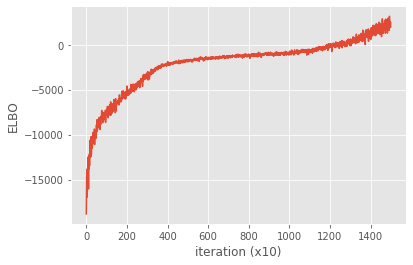

In [17]:
plot_loss(logger)

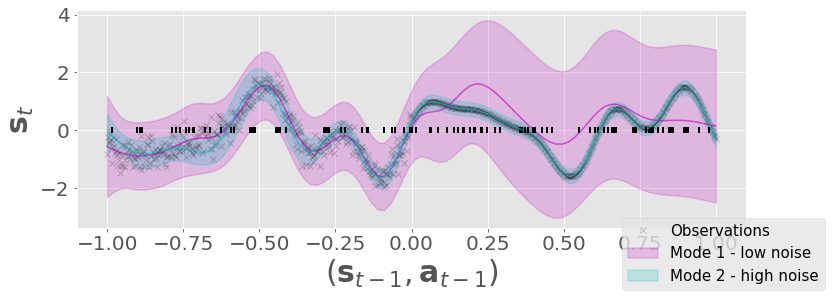

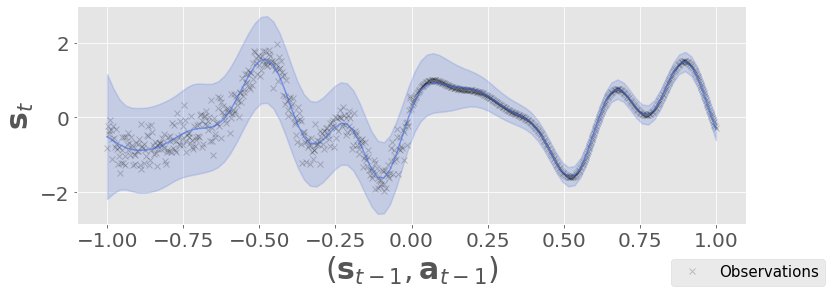

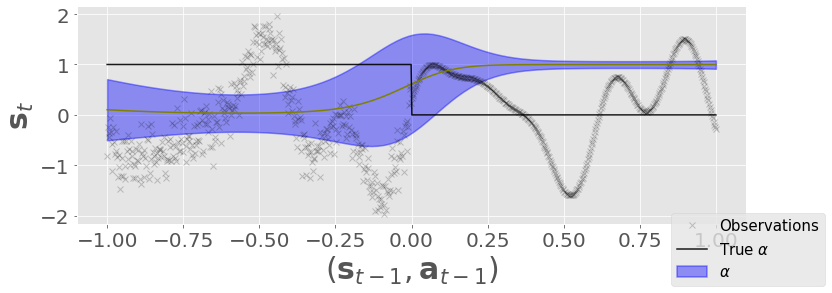

In [18]:
# plot_model(m, m1=True, m2=True, h=True, a=False)
plot_model(m, f1=True, f2=True, a=False)
plot_model(m, y=True)
plot_model(m, a=True, a_true=a)

In [19]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BMNSVGP/feature_h/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.9624530663329163], [0.5018773466833542], [..."
BMNSVGP/features/0/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.16896120150187732], [-0.276595744680851], ..."
BMNSVGP/features/1/Z,Parameter,None,(none),False,"(50, 1)",True,"[[-0.8848560700876095], [-0.7421777221526908],..."
BMNSVGP/kern_h/lengthscales,Parameter,None,+ve,True,(),True,0.48709587427840034
BMNSVGP/kern_h/variance,Parameter,None,+ve,True,(),True,0.802840542641825
BMNSVGP/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.0895384666692982
BMNSVGP/kernels/0/variance,Parameter,None,+ve,True,(),True,1.4429040755860183
BMNSVGP/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.11091301253491558
BMNSVGP/kernels/1/variance,Parameter,None,+ve,True,(),True,1.1836943188281317
BMNSVGP/likelihood/variances/0,Parameter,None,+ve,True,(),True,0.3042362484869302


In [53]:
# session = gpflow.get_default_session()
# pa = session.run(m.p_a_0_tensor)
# # print(pa)
# plt.scatter(m.X, pa)

In [26]:
# saver = gpflow.saver.Saver()
# saver.save('saved_models/joint_inference', m)